# **Generative Adversarial Networks (GANs)**

In this notebook, I will build a Generative Adversarial Network (GAN) and train in on images of Monet paintings and photographs. The trained model will then be able to transform photographs into Monet-style images.

A GAN consists of two kinds of neural network that are trained in competition with each other: **generators** and a **discriminators**. 

A **generator** tries to transform the images in the source set (in our case the photos) into images that look like they belong to the goal set (the Monet paintings). A **discriminator** tries to determine if an image really is a Monet painting, or if it's a fake, i.e. a photograph transformed to look like a Monet paintings. By competing against each other over a number of epochs, the generator and the discriminator will both get better at their respective tasks.

In the setup in this notebook, there will also be a generator transforming images in the other direction: from Monet paintings to photos, and a discriminator that tries to determine if an image is a real or a fake photo.

The project is based on the Kaggle getting-started competition [I'm Something of a Painter Myself[(https://www.kaggle.com/competitions/gan-getting-started/overview).

The code in this notebook can be accessed in my GitHub repository [DTSA-5511-M5-Kaggle-GAN-Monet-Faker](https://github.com/OlaKlingberg/DTSA-5511-M5-Kaggle-GAN-Monet-Faker).

# **Data**

The data used in this notebook is in TFRecords format and consists of:
* 300 Monet RGB images of Monet paintings.
* 7,038 photos of various subjects (though the competition page on Kaggle says that there are 7,028).

All images are RGB (i.e. color) images of size 256 x 256 pixels.



# **Plan**

## Exploratory Data Analysis 
After loading the data, I will output a few photos and Monet images. I will also confirm taht the stated number of images is correct, and that they all have the correct size.

## Data cleaning
Assuming that the photos look like photos, the Monets look like Monets, and that all images have the correct size, there is no data cleaning to do.

## Model building
I will built the generators and discriminator and output graphs showing their architecture. 

## Training and testing the model
After training the model on the entire sets of images, I will use the trained model to generate and output a few Monet-style images based on photos.

## Evaluating the model
The trainig of the model will generate four different loss values: the Monet generator loss, the Monet discriminator loss, the Photo genertor loss, and the Photo discriminator loss. But the Kaggle competition is evaluated using MiFID (Memorization-Informed Fréchet Inception Distance), which is not computable based on those loss values. To find the MiFID score, I will make a submission to the Kaggle competition. The submission will consist of the entire set of photos, transformed by the trained model into Monet-style images.

## Hyper-parameter tuning
I will tune three hyper-parameters:
* Learning rare: 0.0001, 0.0002, 0.0004
* Batch size: 1, 2, 4
* Number of epochs: 15, 25, 40

Since the training of the model is time consuming, I don't aim at exploring all the 27 combinations of the values above.





# **Imports**

In [1]:
!pip install pydot

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets

from IPython.display import FileLink

import PIL

import shutil

2024-10-30 21:31:43.712269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 21:31:43.712413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 21:31:43.856220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Configure processor use**
I will use TPU, GPU, or CPU, in that order, based on availability.

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
        if tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.MirroredStrategy()
            print("Running on GPU.")
        else:
            strategy = tf.distribute.get_strategy()
            print("Running on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Running on GPU.
Number of replicas: 1
2.15.0


# **Configurations to explore**

In [4]:
LEARNING_RATE = 0.0001 # Try: 0.0001, 0.0002, 0.0004
BATCH_SIZE = 1 # Try: 1, 2, 4
EPOCHS = 25 # Try: 15, 25, 40

# **Load the data**

In [5]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [6]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [7]:
IMAGE_SIZE = [256, 256] # Size according to info on the competition page

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1 # Normalize to [-1, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [8]:
# # Function to extract the images
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset

In [9]:
# Load the data sets
monet_ds = load_dataset(MONET_FILENAMES) 
photo_ds = load_dataset(PHOTO_FILENAMES) 

In [10]:
%%time 

# Check the number of images in each data set
monet_count = 0
for _ in monet_ds:
    monet_count += 1

print(f"Number of images in monet_ds: {monet_count}")

photo_count = 0
for _ in photo_ds:
    photo_count += 1

print(f"Number of images in photo_ds: {photo_count}")

Number of images in monet_ds: 300
Number of images in photo_ds: 7038
CPU times: user 11.2 s, sys: 1.68 s, total: 12.9 s
Wall time: 17.8 s


In [11]:
# # Batch the images
monet_ds = monet_ds.batch(BATCH_SIZE) # .batch(1) # Try 1, 2, 4, 8.
photo_ds = photo_ds.batch(BATCH_SIZE) # .batch(1) # Try 1, 2, 4, 8.

# **Exploratory Data Analysis**

## **Check number of photos and Monets**

Remove this after next run.

In [12]:
MONET_JPG = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
PHOTO_JPG = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg')) 

# Display number of files in Monet and Photo directories
print('Number of images in Monet directory: ', len(MONET_JPG))
print('Number of images in photo directory: ', len(PHOTO_JPG))

Number of images in Monet directory:  300
Number of images in photo directory:  7038


## Show 4 photos and 4 Monets

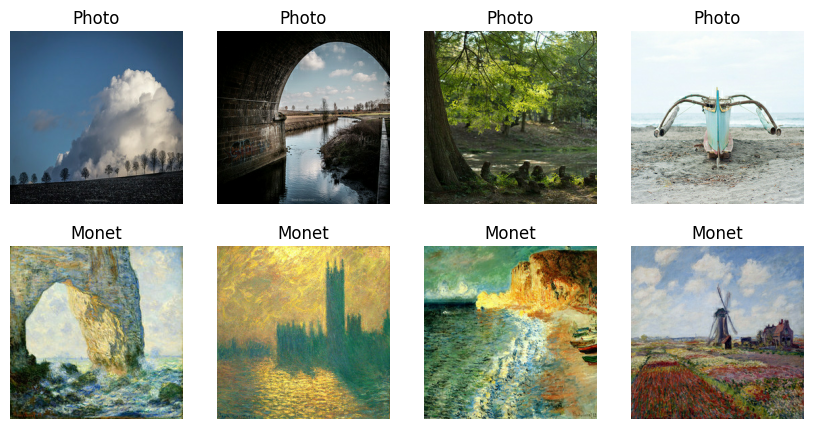

CPU times: user 1.09 s, sys: 358 ms, total: 1.44 s
Wall time: 1.81 s


In [13]:
%%time
# Create iterables from the datasets
monet_iter = iter(monet_ds)
photo_iter = iter(photo_ds)

# Calculate figsize to display images at true size
figsize = (256 * 4 / 100, 256 * 2 / 100)  # 4 columns by 2 rows, at 256x256 pixels per image

fig, ax = plt.subplots(2, 4, figsize=figsize, dpi=100)  # Set dpi to 100 to match pixel size

# Display 4 pairs of images
for i in range(4):
    # First row for Photos
    photo = next(photo_iter)
    ax[0, i].imshow(photo[0] * 0.5 + 0.5)
    ax[0, i].set_title("Photo")
    ax[0, i].axis('off')

    # Second row for Monet
    monet = next(monet_iter)
    ax[1, i].imshow(monet[0] * 0.5 + 0.5)
    ax[1, i].set_title("Monet")
    ax[1, i].axis('off')

plt.show()

# **Generator**

## **Encoder: downsample**

In [14]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides = 2, padding = 'same',
                             kernel_initializer = initializer, use_bias = False))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(gamma_initializer = gamma_init, groups = -1))

    result.add(layers.LeakyReLU())

    return result

## **Decoder: upsample**

In [15]:
def upsample(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides = 2,
                                      padding = 'same',
                                      kernel_initializer = initializer,
                                      use_bias = False))

    result.add(tf.keras.layers.GroupNormalization(gamma_initializer = gamma_init, groups = -1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## **Generator**
The generator downsamples the input image and then upsample and establishes skip connections. Skip connections preserves image information and help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers. 

In [16]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

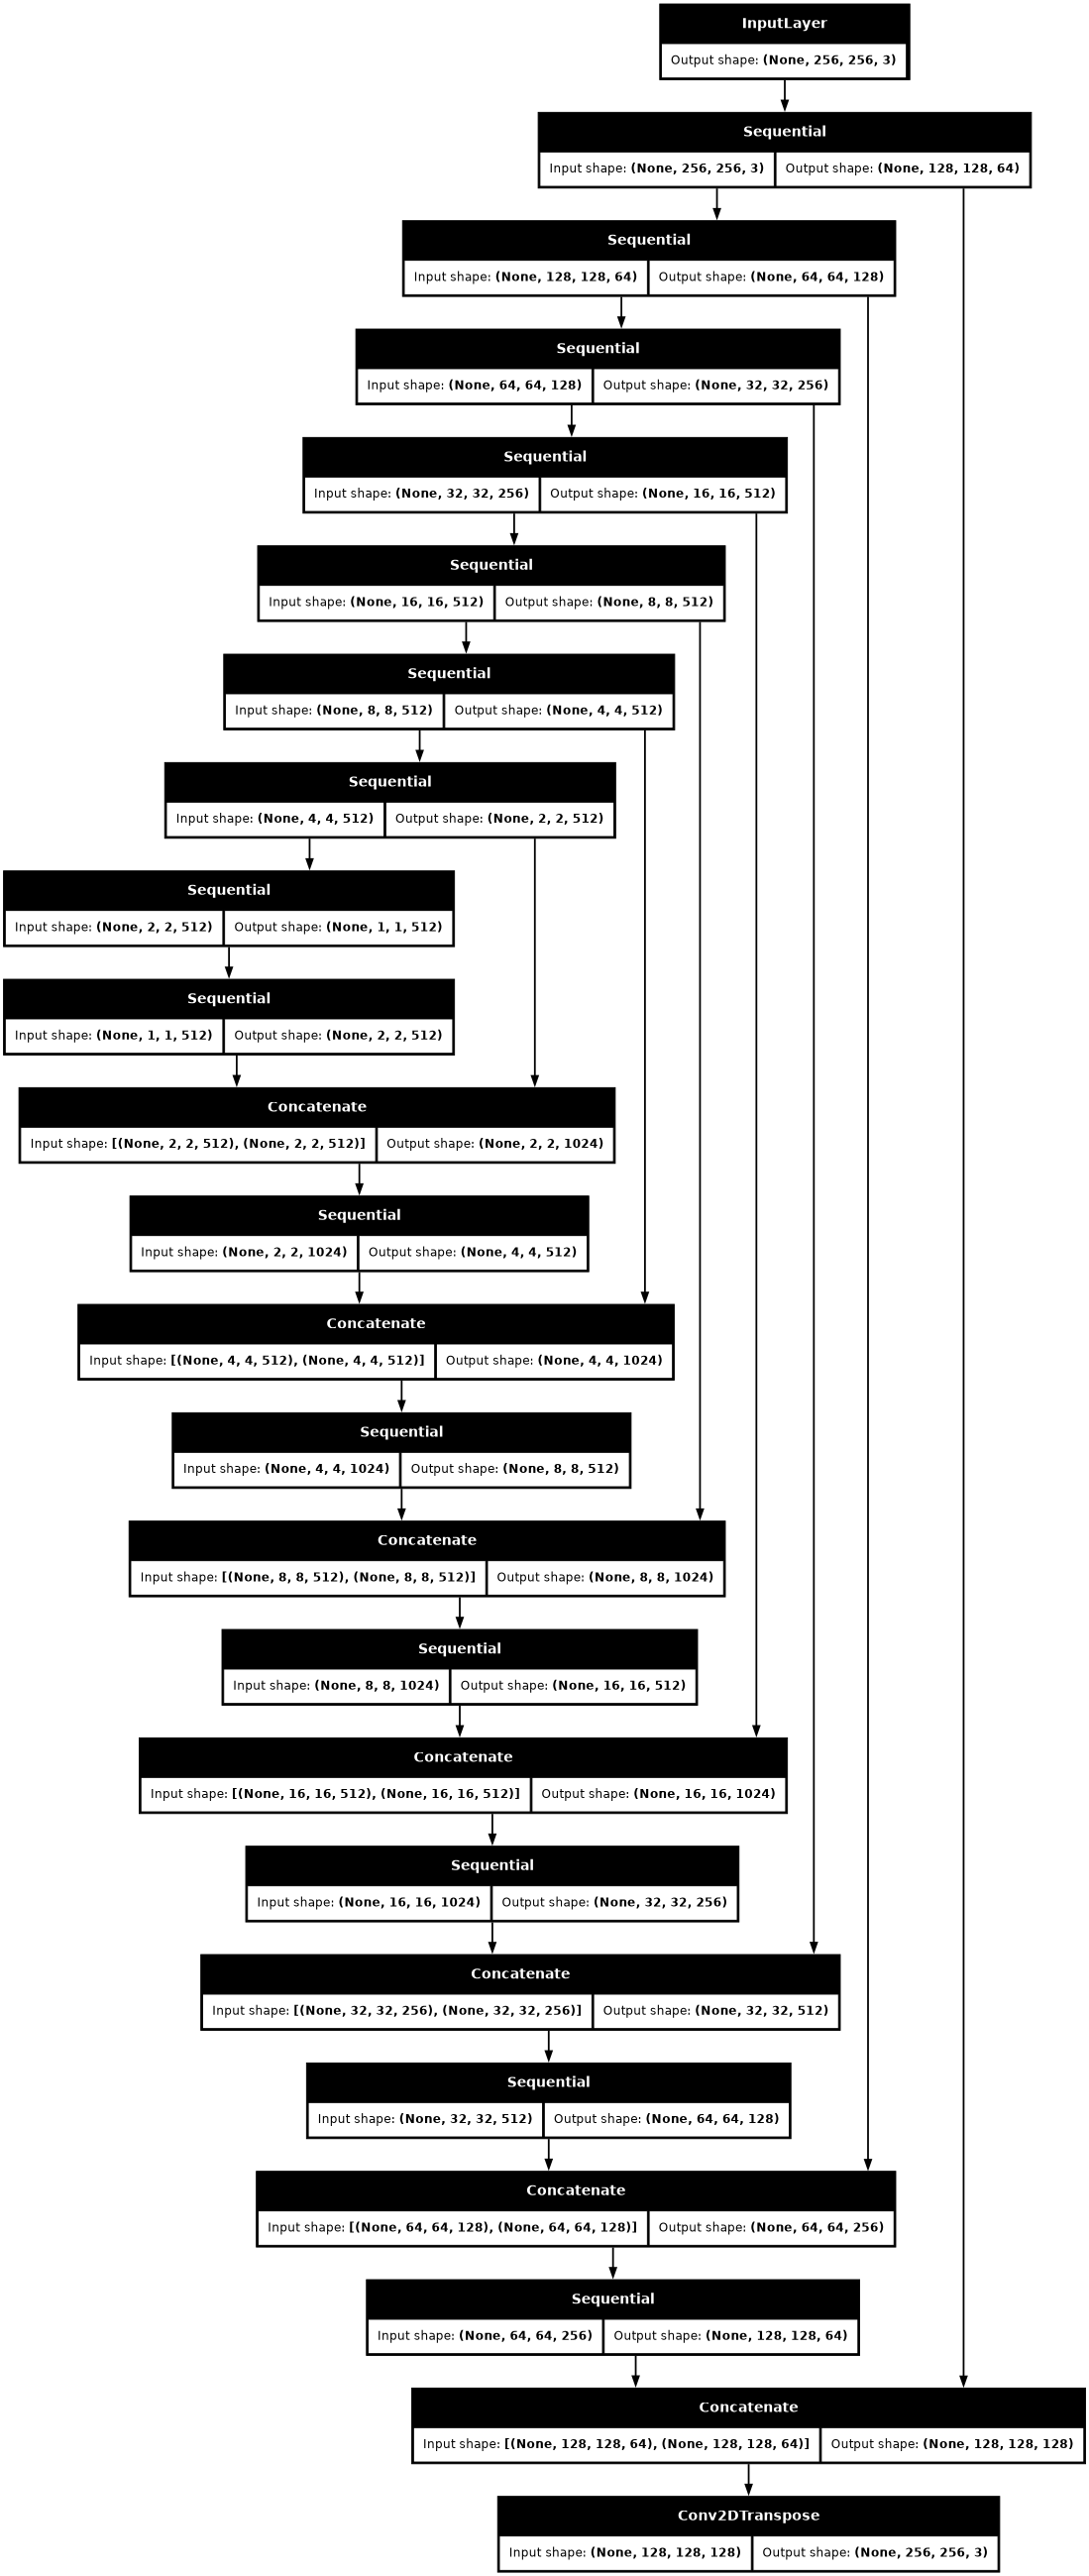

In [17]:
# Create a generator
generator = Generator()

# Vislualize the generator architecture
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

# **Discriminator**

The discriminator classifies the image as real or generated.

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(gamma_initializer = gamma_init, groups = -1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs = inp, outputs = last)

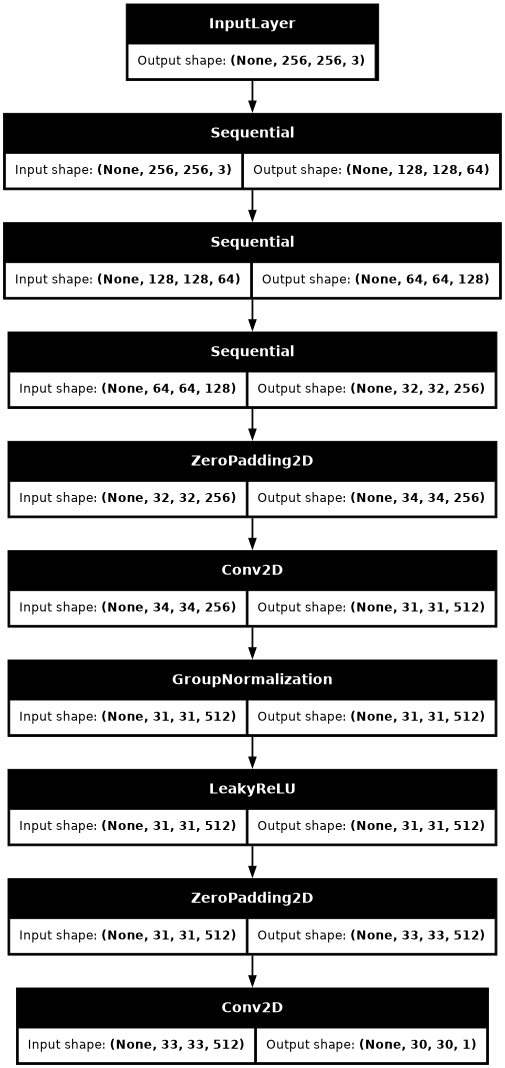

In [19]:
# Create a discriminator
discriminator = Discriminator()

# Visualize the discriminator architecture
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [20]:
with strategy.scope():
    monet_generator = Generator() # Transforms photos to Monet-esque paintings
    photo_generator = Generator() # Transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # Differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # Differentiates real photos and generated photos

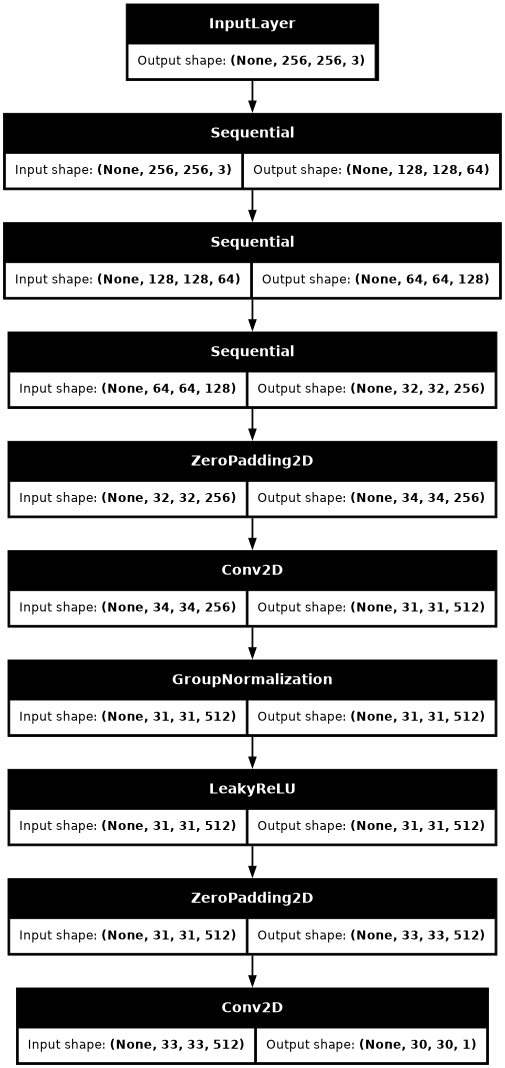

In [21]:
# Visualize the discriminator architecture
tf.keras.utils.plot_model(monet_discriminator, show_shapes=True, dpi=64)

# **CycleGAN model**

In [22]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# **Loss functions**
Loss functions for the generator, discriminator, cycle consistency, and identity.

In [23]:
# Generator loss function
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [24]:
# Discriminator loss function
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [25]:
# Cycle consistency loss function
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [26]:
# Identity loss function
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# **Train the model**

## **Optimizers**

In [27]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.5)

## **Model instantiation**

In [28]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

## **Train the model**

In [29]:
%%time
# cycle_gan_model.fit(
# #     tf.data.Dataset.zip((monet_ds, photo_ds)),
#     tf.data.Dataset.zip((monet_ds.repeat(), photo_ds.repeat())),
#     epochs = EPOCHS 
# )

# cycle_gan_model.fit(
#     tf.data.Dataset.zip((monet_ds, photo_ds)),
#     epochs=1,
# #     steps_per_epoch=1
# )

# Shuffle and repeat for varied sampling each epoch
monet_ds = monet_ds.shuffle(buffer_size=300)  # Monet set is small, so we use the full buffer size
photo_ds = photo_ds.shuffle(buffer_size=1500)  # Shuffle photo set to get varied samples

# Train model with a custom steps_per_epoch if needed
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds.repeat(), photo_ds.repeat())),
    epochs=EPOCHS,
    steps_per_epoch=300  # Or more, based on experimentation
)

Epoch 1/25


2024-10-30 21:33:09.933715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/gradient_tape/functional_35_5/sequential_28_1/dropout_5_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 ━━━━━━━━━━━━━━━━━━━━ 154s 284ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 6.1516 - photo_disc_loss: 0.5685 - photo_gen_loss: 6.3502
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 85s 284ms/step - monet_disc_loss: 0.6531 - monet_gen_loss: 4.0742 - photo_disc_loss: 0.6134 - photo_gen_loss: 4.1873
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 85s 284ms/step - monet_disc_loss: 0.6557 - monet_gen_loss: 3.7398 - photo_disc_loss: 0.4357 - photo_gen_loss: 4.1955
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 85s 284ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 3.7780 - photo_disc_loss: 0.5038 - photo_gen_loss: 4.1672
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 85s 284ms/step - monet_disc_loss: 0.6410 - monet_gen_loss: 3.7439 - photo_disc_loss: 0.5416 - photo_gen_loss: 4.1289
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 85s 284ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 3.7109 - photo_disc_loss: 0.5349 - photo_gen_loss: 4.0792
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 85s 284ms/step - monet_disc_

# Visualize our Monet-esque photos

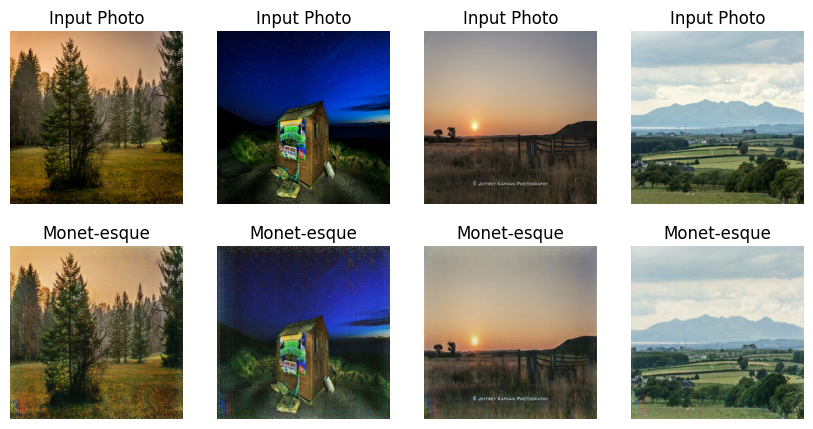

CPU times: user 3.64 s, sys: 477 ms, total: 4.11 s
Wall time: 4.13 s


In [30]:
%%time
# Calculate figsize to display images at true size
figsize = (256 * 4 / 100, 256 * 2 / 100)  # 4 columns by 2 rows, at 256x256 pixels per image

fig, ax = plt.subplots(2, 4, figsize=figsize, dpi=100)  # Set dpi to 100 to match pixel size
for i, img in enumerate(photo_ds.take(4)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    # Show photos
    ax[0, i].imshow(img)
    ax[0, i].set_title("Input Photo")
    ax[0, i].axis("off")

    # Show Monet-esque version
    ax[1, i].imshow(prediction)
    ax[1, i].set_title("Monet-esque")
    ax[1, i].axis("off")

plt.show()



# Create submission file

In [31]:
directory = '/kaggle/working/images'
if not os.path.exists(directory):
    os.makedirs(directory)

In [32]:
%%time
i = 1
for img in photo_ds:
    if i % 500 == 0:
        print(f"Processed {i} out of 7,038 images.")
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/kaggle/working/images/" + str(i) + ".jpg")
    i += 1


Processed 500 out of 7,038 images.
Processed 1000 out of 7,038 images.
Processed 1500 out of 7,038 images.
Processed 2000 out of 7,038 images.
Processed 2500 out of 7,038 images.
Processed 3000 out of 7,038 images.
Processed 3500 out of 7,038 images.
Processed 4000 out of 7,038 images.
Processed 4500 out of 7,038 images.
Processed 5000 out of 7,038 images.
Processed 5500 out of 7,038 images.
Processed 6000 out of 7,038 images.
Processed 6500 out of 7,038 images.
Processed 7000 out of 7,038 images.
CPU times: user 8min 27s, sys: 1.33 s, total: 8min 28s
Wall time: 8min 18s


In [33]:
shutil.make_archive(base_name = "/kaggle/working/images", 
                    format = 'zip', 
                    root_dir = "/kaggle/working/images")

'/kaggle/working/images.zip'

In [34]:
# Generate a download link
filename = 'images.zip'
FileLink(rf'{filename}')

/kaggle/working/images.zip